In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/knotek/jupyterlab/source/semantic-segmentation


/home/knotek/miniconda3/envs/semseg/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Requirements:
```
torch
tqdm
albumentations
opencv-python
imageio
numpy==1.26.0
pandas
scipy
scikit-learn
segmentation-models-pytorch
matplotlib
```

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from pathlib import Path
root = Path('/home/knotek/jupyterlab/data/delisa_2024/labeled/')
with open(root/'test.txt') as f:
    test_names= {f.strip() for f in f.readlines()}

# Load Images

In [28]:
import imageio.v3 as imageio
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

img_all_paths = list(root.rglob('40*/**/img.png'))

img_paths = []
test_img_paths = []
for p in img_all_paths:
    sample_name = p.parent.name
    if sample_name in test_names:
        test_img_paths.append(p)
    else:
        img_paths.append(p)

def read_img(p):
    img = imageio.imread(p)
    if len(img.shape) > 2:
        return np.float32(img[:,:,0]/255)
    else:
        return np.float32(img/255)

label_paths = [ p.parent/'label.png' for p in img_paths]

imgs = [read_img(img_path) for img_path in tqdm(img_paths)]
labels = [ read_img(label_path) for label_path in tqdm(label_paths)]

test_label_paths = [ p.parent/'label.png' for p in test_img_paths]
test_imgs = [read_img(img_path) for img_path in tqdm(test_img_paths)]
test_labels = [ read_img(label_path) for label_path in tqdm(test_label_paths)]

100%|██████████| 10/10 [00:00<00:00, 144.05it/s]


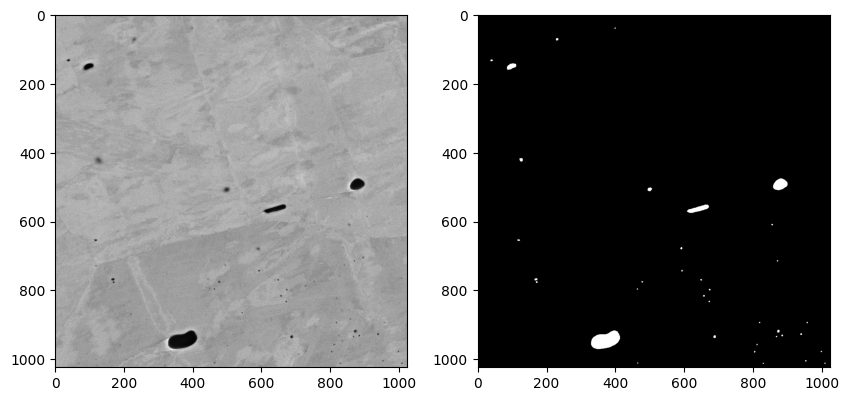

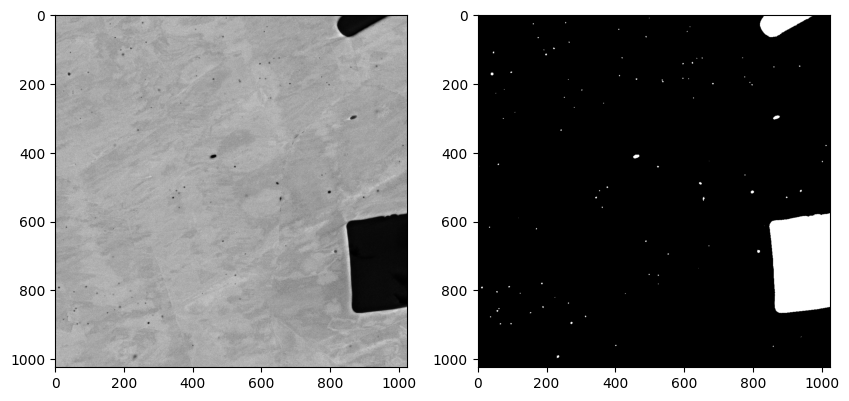

In [5]:
for img,label in zip(imgs,labels[:2]):
    fig,(axl,axr) = plt.subplots(1,2,figsize = (10,5))
    axl.imshow(img,cmap='gray')
    axr.imshow(label,cmap='gray')
    plt.show()

# Augumentation

Apply augumentation to increase variability in dataset

In [6]:
import albumentations as A

patch_size = 256

transformations = [
    A.ElasticTransform(
        p=0.5,
        alpha=10,
        sigma=12,
        alpha_affine=12
    ),
    A.Rotate(limit=15),
    A.RandomCrop(patch_size, patch_size), 
    A.PadIfNeeded(patch_size, patch_size),
    A.augmentations.transforms.GaussNoise(.01, p=0.5),
    A.OneOf(
        [
            A.Sharpen(p=1, alpha=(0.2, 0.2)),
            A.Blur(blur_limit=3, p=1),
        ],
        p=0.3,
    ),
    A.HorizontalFlip(p=0.25),    
    A.VerticalFlip(p=0.25),
]
train_augumentation = A.Compose(transformations)
val_augumentation = A.Compose([
    A.RandomCrop(patch_size, patch_size),
    A.PadIfNeeded(patch_size, patch_size)
])

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


# DataLoaders

Notice that segmentation dataset returns a dictionary with training image `x` and its ground truth `y`. 

In order to increase model's "understanding", the ground truth composes of three classes:
- foreground (precipitates)
- background (matrix)
- borders


In [7]:
import cv2
import numpy as np
import sklearn.model_selection as ms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        images,
        labels,
        transform,
    ):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.images)

    def _get_border(self, foreground_label):
        fg_int = np.uint8(foreground_label)
        kernel = np.ones((3, 3))
        eroded = cv2.morphologyEx(fg_int, cv2.MORPH_ERODE, kernel)
        return np.float32(fg_int - eroded)

    def _transform(self, image, label):
        transformed = self.transform(image=image, mask=label)
        tr_image = transformed["image"]
        tr_label = transformed["mask"]
        return tr_image, tr_label

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image_aug, label_aug = self._transform(image, label)

        foreground = np.float32(label_aug > 0)
        background = 1 - foreground
        border = self._get_border(foreground)
        y = np.stack([foreground, background, border])
        x = np.stack([image_aug],dtype=np.float32)

        return {
            "x": x,
            "y": y,
        }
   
img_train, img_val, label_train, label_val = ms.train_test_split(
    imgs, 
    labels, 
    test_size=.2, 
    random_state=123
)

dataset_train = SegmentationDataset(
    img_train,
    label_train,
    train_augumentation
)
train_dataloader = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
)

dataset_val = SegmentationDataset(
    img_val,
    label_val,
    val_augumentation
)
val_dataloader = DataLoader(
    dataset_val,
    batch_size=32,
    shuffle=False,
)

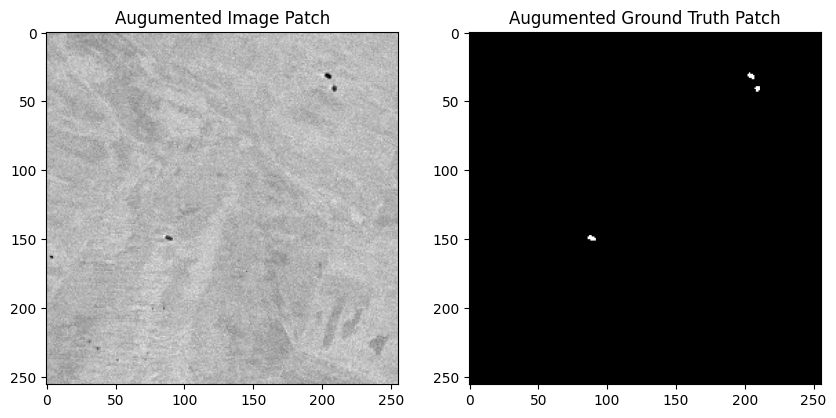

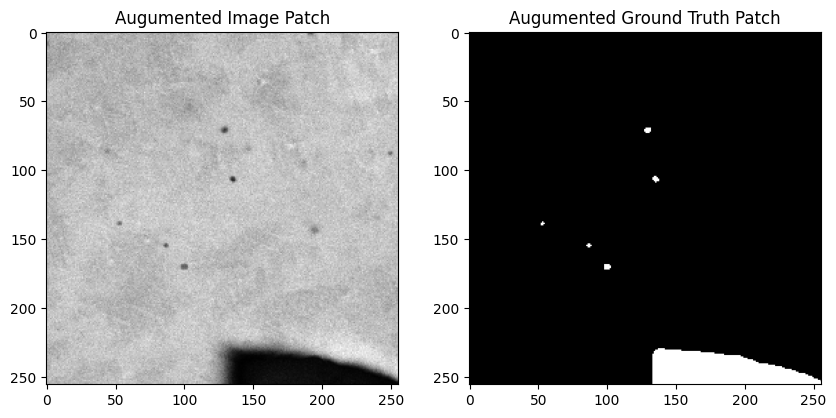

In [17]:
for td,_ in zip(dataset_train,range(2)):
    fig,(axl,axr) = plt.subplots(1,2,figsize = (10,5))
    axl.set_title("Augumented Image Patch")
    axl.imshow(td['x'][0],cmap='gray')
    axr.imshow(td['y'][0],cmap='gray')
    axr.set_title("Augumented Ground Truth Patch")
    plt.show()

# Model

Five-layer deep Unet with preloaded imagenet weights. It's three output classes corresponds to the ones discussed in dataset section.

In [18]:
from segmentation_models_pytorch import Unet

model = Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=3,
    decoder_channels = [128,  64,  32,  16,   8],
    activation="sigmoid"
)

# Loss

In [19]:
import torch
from torch.functional import F

class FocalLoss(torch.nn.Module):
    def __init__(
        self,
        alpha=0.8,
        gamma=2,
        reduction="mean",
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy(inputs, targets, reduction=self.reduction)
        bce_exp = torch.exp(-bce)
        return self.alpha * (1 - bce_exp) ** self.gamma * bce

loss = FocalLoss(alpha = .8,gamma=2)

# Training



In [20]:
from tqdm.contrib.logging import logging_redirect_tqdm
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 60
learning_rate = 0.001

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
train_losses_per_epoch = []
validation_losses_per_epoch = []

with tqdm(range(0,epochs), desc="Training epochs") as t:
    for epoch in t:
        # Training
        model.train()
        train_losses = []
        # train step
        for targets in train_dataloader:
            optimizer.zero_grad()
            device_targets = {k: v.to(device) for k, v in targets.items()}
            x = device_targets["x"]
            pred = model(x)
            y = device_targets["y"]
            ls = loss(pred,y)

            ls.backward()
            optimizer.step()
            train_losses.append(ls.item())  
            
        train_losses_per_epoch.append(np.mean(train_losses))

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for targets in val_dataloader:
                device_targets = {k: v.to(device) for k, v in targets.items()}
                x = device_targets["x"]
                pred = model(x)
                y = device_targets["y"]
                loss_val = loss(pred,y)
                val_losses.append(loss_val.item())

        val_loss = np.mean(val_losses)
        validation_losses_per_epoch.append(val_loss)
        t.set_postfix(epoch=epoch,validation_loss=val_loss)

Training epochs: 100%|██████████| 60/60 [09:28<00:00,  9.47s/it, epoch=59, validation_loss=0.00132]


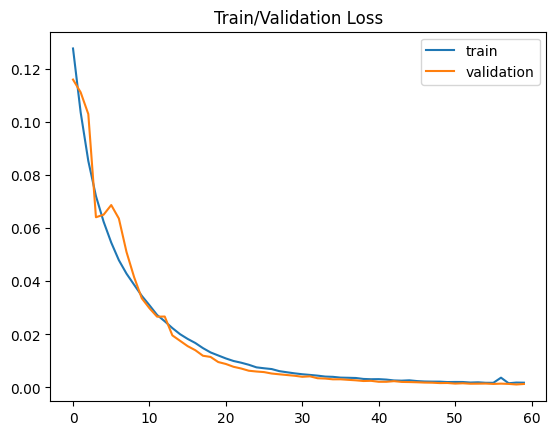

In [21]:
plt.plot(train_losses_per_epoch,label='train')
plt.plot(validation_losses_per_epoch,label='validation')
plt.title("Train/Validation Loss")
plt.legend()

# Test

Measure the results on never seen data

In [22]:
# Padding and unpadding are used because input data can have various shapes

def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h - h) / 2), int(new_h - h) - int((new_h - h) / 2)
    lw, uw = int((new_w - w) / 2), int(new_w - w) - int((new_w - w) / 2)
    pads = (lw, uw, lh, uh)
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2] + pad[3] > 0:
        x = x[:, :, pad[2] : -pad[3], :]
    if pad[0] + pad[1] > 0:
        x = x[:, :, :, pad[0] : -pad[1]]
    return x

test_predictions = []
for test_img in tqdm(test_imgs,desc='Testing'):
    test_img = test_img[None] # add channel dimension
    with torch.no_grad():
        tensor = torch.from_numpy(test_img).to(device)
        tensor = tensor[None]  # To add batch dimension
        padded_tensor, pads = pad_to(tensor, 32)
        res_tensor = model(padded_tensor)[0]
        res_unp = unpad(res_tensor, pads)
        test_predictions.append(res_unp.cpu().detach().numpy())

Testing: 100%|██████████| 10/10 [00:00<00:00, 44.53it/s]


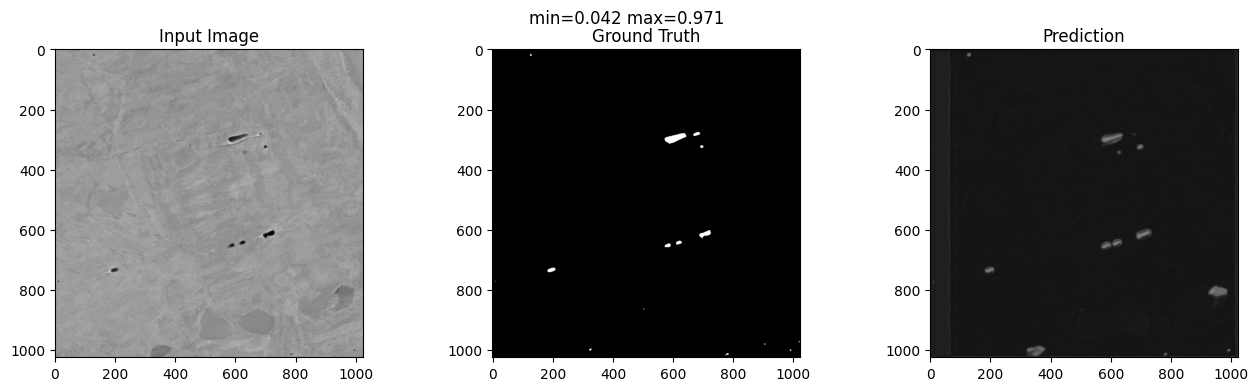

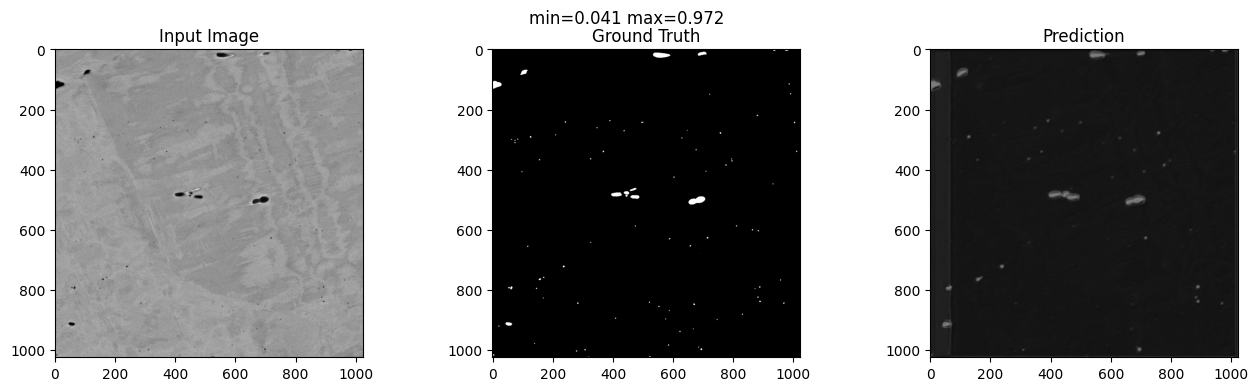

In [25]:
for img,label,pred in zip(test_imgs,test_labels,test_predictions[:2]):
    fig,axs = plt.subplots(1,3,figsize=(16,4))
    axs[0].imshow(img,vmin=0,vmax=1,cmap='gray')
    axs[0].set_title("Input Image")
    axs[1].imshow(label,vmin=0,vmax=1,cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred[0],vmin=0,vmax=1,cmap='gray')
    axs[2].set_title("Prediction")
    title = f"min={np.min(pred):.3f} max={np.max(pred):.3f}"
    plt.suptitle(title)
    plt.show()

# Test - Instance Analysis

1) Extract individual components from both images
2) Find best match
3) Calculate metrics

The main metric to track is $F_1$ - harmonic average of precision and recall $F_1 = 2\frac{precision \cdot recall}{ precision + recall}$.

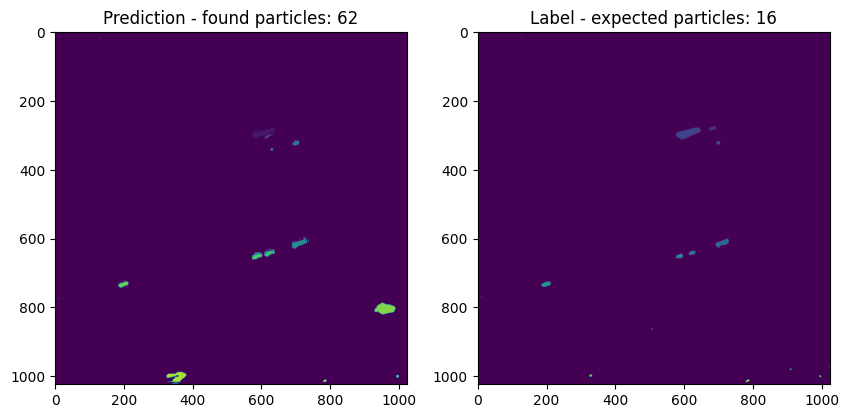

In [26]:
threshold=  .3
bin_prediction = np.uint8(test_predictions[0][0]>=threshold)
label = np.uint8(test_labels[0])

p_n, p_grains = cv2.connectedComponents(bin_prediction)
l_n, l_grains = cv2.connectedComponents(label)

_,(axl,axr)=plt.subplots(1,2,figsize=(10,5))

axl.imshow(p_grains)
axl.set_title(f"Prediction - found particles: {p_n}")
axr.imshow(l_grains)
axr.set_title(f"Label - expected particles: {l_n}")
plt.show()

In [27]:
import pandas as pd
from torchmetrics.classification import BinaryJaccardIndex
import scipy.optimize

import itertools

def _pair_using_linear_sum_assignment(p_n, p_grains, l_n, l_grains, cap=500):
    if cap is not None:
        p_n = min(cap, p_n)
        p_grains[p_grains > cap] = 0

        l_n = min(cap, l_n)
        l_grains[l_grains > cap] = 0

    weights_dict = _collect_pairing_weights(p_n, p_grains, l_n, l_grains)
    weights, p_map, l_map = _construct_weight_map(weights_dict)
    p_item_id, l_item_id = scipy.optimize.linear_sum_assignment(weights)

    inverse_p_map = {v: k for k, v in p_map.items()}
    p_item = np.array([inverse_p_map[idx] for idx in p_item_id])
    inverse_l_map = {v: k for k, v in l_map.items()}
    l_item = np.array([inverse_l_map[idx] for idx in l_item_id])
    return p_item, l_item


def _construct_weight_map(weights_dict):
    p_map = {}

    for i, v in enumerate(weights_dict.keys()):
        p_map[v] = i

    l_keys = itertools.chain(
        *(list(k for k in v.keys()) for v in weights_dict.values())
    )
    l_unique = np.unique(list(l_keys))
    l_map = {}
    for i, v in enumerate(l_unique):
        l_map[v] = i

    weights = np.zeros((len(p_map), len(l_map)))
    for i, (p, pv) in enumerate(weights_dict.items()):
        for ll, lv in pv.items():
            weights[p_map[p], l_map[ll]] = lv
    return weights, p_map, l_map


def _collect_pairing_weights(p_n, p_grains, l_n, l_grains):
    weights_dict = {}
    iou = prepare_iou()
    for p_grain_id in range(1, p_n):
        p_grain_mask = np.uint8(p_grains == p_grain_id)

        intersecting_ids = np.unique(l_grains * p_grain_mask)
        intersecting_ids = intersecting_ids[intersecting_ids > 0]

        for l_grain_id in intersecting_ids:
            l_grain_mask = np.uint8(l_grains == l_grain_id)

            weight = 1 - iou(l_grain_mask, p_grain_mask)
            weights_dict.setdefault(p_grain_id, {}).setdefault(l_grain_id, weight)

    return weights_dict

def prepare_iou(foreground_thr=0.5):
    m = BinaryJaccardIndex(threshold=foreground_thr)

    def met(a, b):
        a = np.where(a < foreground_thr, 0, 1)
        b = np.where(b < foreground_thr, 0, 1)
        return m(torch.Tensor(a), torch.Tensor(b))

    return met


precisions = []
recalls = []
for label,prediction in tqdm(list(zip(test_labels,test_predictions)),desc = "Matching precipitates"):
    foreground = prediction[0]
    pred_thr = np.uint8(foreground>=threshold)
    label_thr = np.uint8(label)
    
    p_n, p_grains = cv2.connectedComponents(pred_thr)
    l_n, l_grains = cv2.connectedComponents(label_thr)

    pred_items, label_items = _pair_using_linear_sum_assignment(
        p_n, p_grains, l_n, l_grains
    )
    data = list(zip(pred_items, label_items))

    p_set = set(pred_items)
    false_positives = [i for i in range(1, p_n) if i not in p_set]
    for i in false_positives:
        data.append((i, None))

    l_set = set(label_items)
    label_positives = [i for i in range(1, l_n) if i not in l_set]
    for i in label_positives:
        data.append((None, i))
    df = pd.DataFrame(data, columns=["pred_id", "label_id"])
    
    grains_pred = len(df[~df["pred_id"].isna()])
    grains_label = len(df[~df["label_id"].isna()])

    tp = df[~df["label_id"].isna() & ~df["pred_id"].isna()]
    if grains_pred != 0:
        precision = len(tp) / grains_pred
    else:
        precision = np.nan

    if grains_label != 0:
        recall = len(tp) / grains_label
    else:
        recall = np.nan

    precisions.append(precision)
    recalls.append(recall)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = 2* (mean_precision*mean_recall)/(mean_precision + mean_recall)

print(f"{mean_precision=:.2f} {mean_recall=:.2f} {mean_f1=:.2}")

Matching precipitates: 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

mean_precision=0.41 mean_recall=0.64 mean_f1=0.5


# Next Steps

- Find best threshold on a precision/recall curve
- Weightmaps to improve separation of close precipitates